# Prediction on Higher-Priced Mortgage Loan 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
import itertools
import datetime
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC
import copy 

# set seed
SEED = 12345
# set number of threads
NTHREAD = 4

## Import data & Assign basic modeling roles

In [1]:
%cd /Users/alex/Desktop/Master/Responsible_ML_DNSC6209_11/dataset/

/Users/alex/Desktop/Master/Responsible_ML_DNSC6209_11/dataset


In [3]:
# load train and test data sets
tr_df = pd.read_csv("hmda_train_preprocessed.csv") # the given training data set
test = pd.read_csv("hmda_test_preprocessed.csv") # the given test data set

In [4]:
# basic information on the data set 
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160338 entries, 0 to 160337
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   row_id                        160338 non-null  int64  
 1   black                         137790 non-null  float64
 2   asian                         137790 non-null  float64
 3   white                         137790 non-null  float64
 4   amind                         137790 non-null  float64
 5   hipac                         137790 non-null  float64
 6   hispanic                      137877 non-null  float64
 7   non_hispanic                  137877 non-null  float64
 8   male                          86537 non-null   float64
 9   female                        86537 non-null   float64
 10  agegte62                      81414 non-null   float64
 11  agelt62                       81414 non-null   float64
 12  term_360                      160338 non-nul

In [5]:
# assign reponse and predictors 
y_name = "high_priced"
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Data Exploration

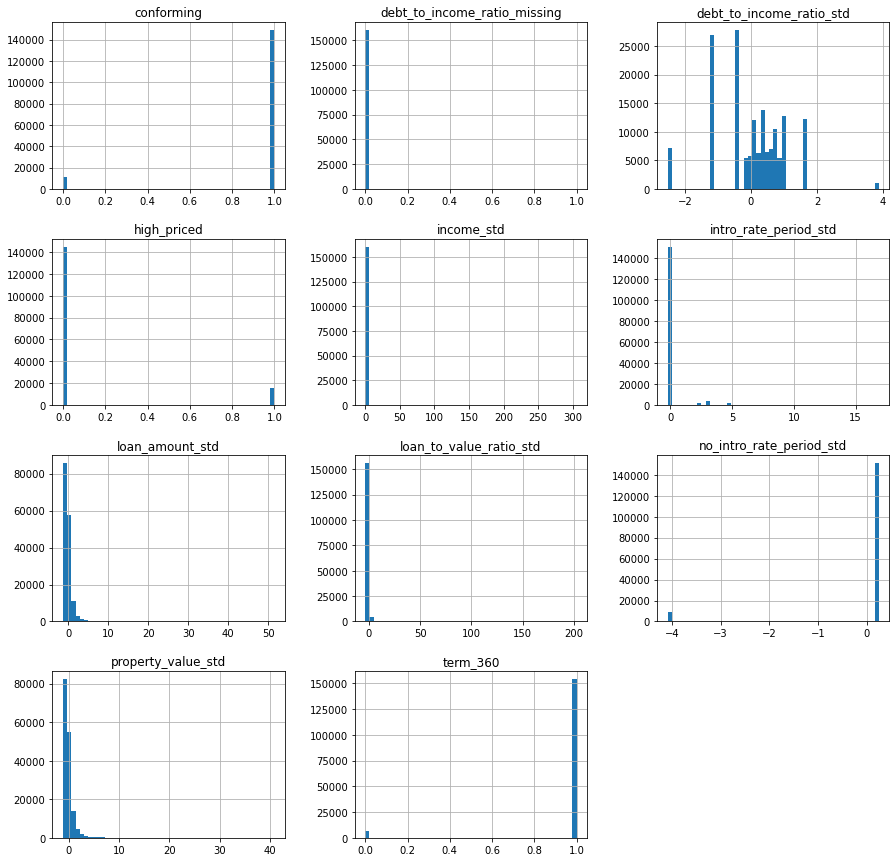

In [6]:
# Histograms
_ = tr_df[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

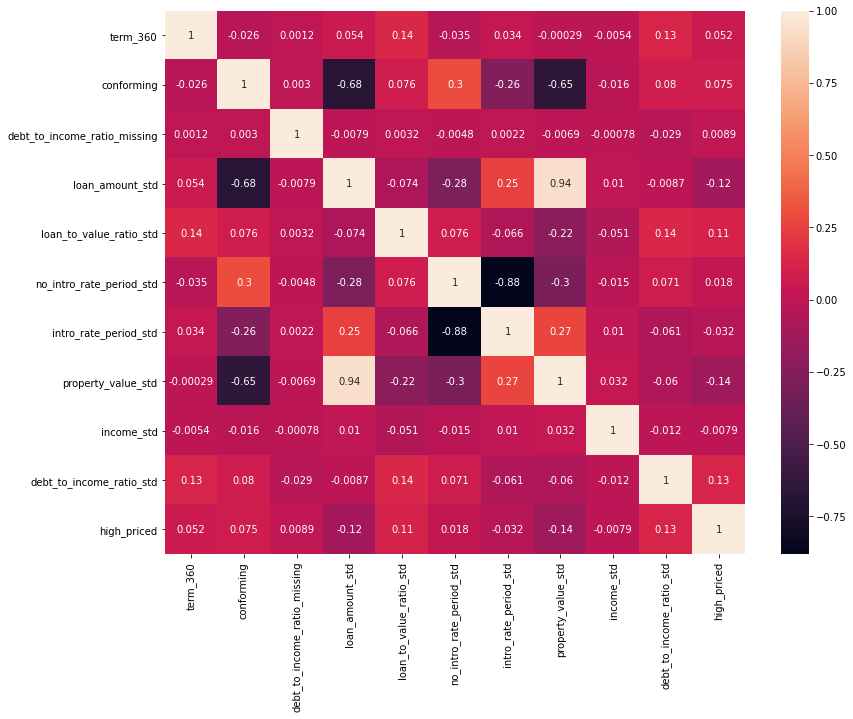

In [7]:
# Check Multicollinearity 
plt.figure(figsize = (13,10))

corr = tr_df[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, annot = True)

In [8]:
# loan_amount_std & property_value_std are highly correlated with the correlation 0.94. 
# Generate a new interaction feature by multiplying the two features
tr_df["loan_amt:prprty_vl"] = tr_df["loan_amount_std"]*tr_df["property_value_std"]
test["loan_amt:prprty_vl"] = test["loan_amount_std"]*test["property_value_std"]

In [9]:
# Add the new feature to the x_names list
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
          'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std', 'loan_amt:prprty_vl']

In [10]:
# Check null values 
tr_df[x_names+[y_name]].isnull().sum() # no null-value is detected

term_360                        0
conforming                      0
debt_to_income_ratio_missing    0
loan_amount_std                 0
loan_to_value_ratio_std         0
no_intro_rate_period_std        0
intro_rate_period_std           0
property_value_std              0
income_std                      0
debt_to_income_ratio_std        0
loan_amt:prprty_vl              0
high_priced                     0
dtype: int64

## Split Train & Test Sets

In [11]:
# Split train and validation sets 
np.random.seed(SEED)

ratio = 0.7 # split train & validation sets with 7:3 ratio 

split = np.random.rand(len(tr_df)) < ratio # define indices of 70% corresponding to the training set

train = tr_df[split]
valid = tr_df[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112253, columns = 24
Validation data rows = 48085, columns = 24


## XGBoosting Machine

### Random Grid Search for XGBoost

In [12]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

### Fit XGBoost

In [13]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/50: 0.7906.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1)}
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_byt

---------- ----------
Grid search run 21/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1)}
---------- ----------
Grid search run 22/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1)}
Grid search new best score discovered at iteration 22/50: 0.7918.
---------- ----------
Grid search run 23/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric

---------- ----------
Grid search run 41/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1)}
---------- ----------
Grid search run 42/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1)}
---------- ----------
Grid search run 43/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed':

### AUC assessment (MXGB)

In [17]:
# Print AUC of the best trained model
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7924.


### Model Score (Prediction on test set)

In [48]:
dtest = xgb.DMatrix(test[x_names])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
#best_mxgb_submit.to_csv('Group7_XGBoost.csv', index=False)

## Explainable Boosting Machine (EBM)

### Random Grid Search for EBM

In [18]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

### Fit EBM

In [16]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8220.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

### AUC assessment (EBM)

In [19]:
# Print AUC of the best trained model 
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8249.


### Model Score (Prediction on test set)

In [53]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1], columns=['phat'])
#best_mxgb_submit.to_csv('Group7_EBM.csv', index=False)

### -----------------------------------------------------------------------------------------------------------

## Globaly and locally explainable & Interpretable models


### Scoring validation data with model 

In [20]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat']) 
best_mxgb_phat = pd.concat([valid[["row_id"] + x_names].reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,row_id,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,loan_amt:prprty_vl,phat
0,0,1,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0.275680,0.251763
1,6,1,1,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0.202249,0.263347
2,8,1,1,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0.030925,0.027177
3,10,1,1,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0.122426,0.022311
4,11,1,1,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0.011296,0.006523


### 1. Feature Importance

### 1.1 XGB model: Shapley values

In [21]:
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, iteration_range=(0, best_mxgb.best_ntree_limit))

In [22]:
shap_contribs_matrix = np.matrix(shapley_contribs)
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 1.37494765e-02  1.34243368e-04  0.00000000e+00 ...  2.55302280e-01
  -4.90228795e-02 -2.35155201e+00]
 [ 1.63126737e-02  1.58838491e-04  0.00000000e+00 ...  3.11616331e-01
   7.24987313e-02 -2.35155201e+00]
 [ 1.78760905e-02  1.33937821e-04  0.00000000e+00 ... -8.38455707e-02
   3.47615361e-01 -2.35155201e+00]
 ...
 [ 2.26426683e-02  2.25748736e-04  0.00000000e+00 ... -7.57299662e-01
   4.03150171e-01 -2.35155201e+00]
 [ 3.12212668e-02  1.33937821e-04  0.00000000e+00 ...  3.25666405e-02
   1.43645465e-01 -2.35155201e+00]
 [ 1.30398087e-02  2.14554137e-04  0.00000000e+00 ...  6.47050858e-01
  -2.27117285e-01 -2.35155201e+00]]

Shapley contributions rows = 48085, columns = 12


* shapley values are calculated on each and every single row of each column:
* the matrix contains the Shapley values of which rows and columns are equal to the validation set + intercept column

### Mean Abs Shapley values 


* the average absolute Shapley value for each input feature

In [23]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=x_names + ['intercept'])
global_fi = pd.DataFrame(np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean(), columns = ['MXGB Importance'])
print(global_fi)

                              MXGB Importance
term_360                             0.078708
conforming                           0.000639
debt_to_income_ratio_missing         0.000000
loan_amount_std                      0.581068
loan_to_value_ratio_std              0.998070
no_intro_rate_period_std             0.004438
intro_rate_period_std                0.044310
property_value_std                   0.257469
income_std                           0.025604
debt_to_income_ratio_std             0.332257
loan_amt:prprty_vl                   0.363892


### Bar chart on the Shapley values


Text(0, 0.5, 'Features')

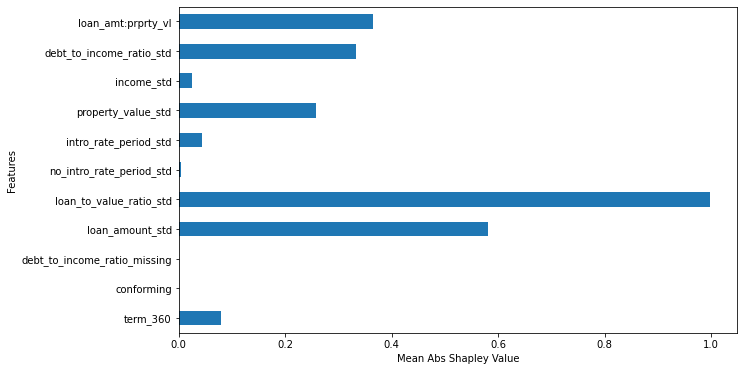

In [24]:
# plot bar chart on the global_fi to see the global feature importance
fig, ax = plt.subplots(figsize=(10,6))
global_fi["MXGB Importance"].plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Mean Abs Shapley Value')
ax.set_ylabel('Features')

### 1.2 EBM: Feature score 

### Score validation data with model

In [25]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,loan_amt:prprty_vl,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.275680,0.168647
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.202249,0.325303
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.030925,0.023970
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.122426,0.015600
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.011296,0.004064


### Calculate EBM contributions

In [30]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, -1), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

EBM contributions collected in 77.32 s.


### Collect global feature importance info

In [31]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()
print(global_fi)

                              MXGB Importance  EBM Importance
term_360                             0.078708        0.072837
conforming                           0.000639        0.068621
debt_to_income_ratio_missing         0.000000        0.001284
loan_amount_std                      0.581068        0.284713
loan_to_value_ratio_std              0.998070        0.890785
no_intro_rate_period_std             0.004438        0.063735
intro_rate_period_std                0.044310        0.106018
property_value_std                   0.257469        0.358972
income_std                           0.025604        0.158046
debt_to_income_ratio_std             0.332257        0.386111
loan_amt:prprty_vl                   0.363892        0.122224


### Plot the feature importance of EBM model

Text(0, 0.5, 'Features')

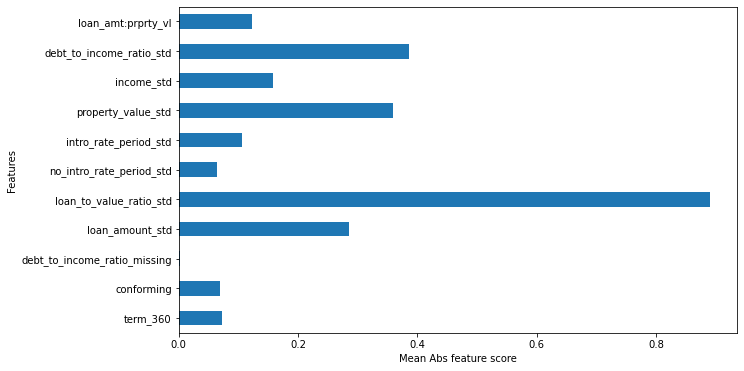

In [32]:
# plot bar chart on the global_fi to see the global feature importance
fig, ax = plt.subplots(figsize=(10,6))
global_fi["EBM Importance"].plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Mean Abs feature score')
ax.set_ylabel('Features')

### 1.3 Comparing global feature importance across the two models


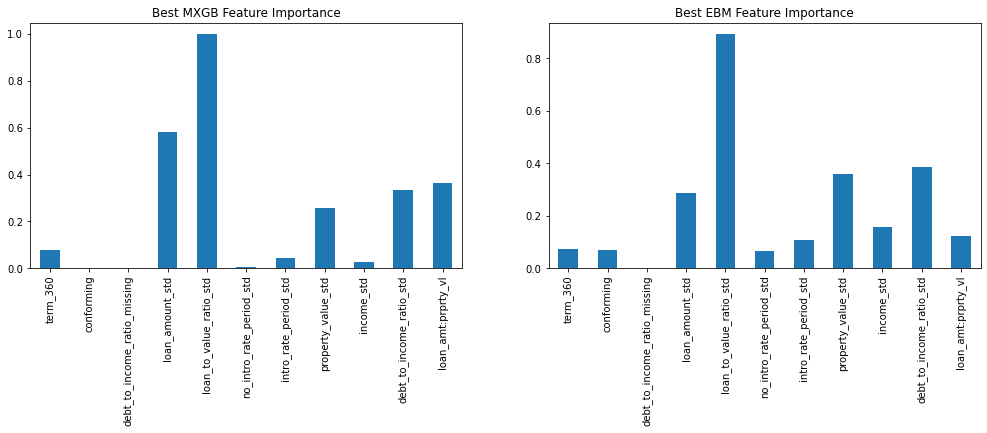

In [33]:
# init 3-pane plot 
fig, (ax0, ax1) = plt.subplots(ncols=2)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_fi['MXGB Importance'].plot(kind='bar', ax=ax0, title='Best MXGB Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax1, title='Best EBM Feature Importance')

* "loan_to_value_ratio_std" is commonly shared between the two models as the most important feature in terms of predicting the response "high_priced".


* "loan_amount_std" is treated as the secondly significant variable in the MXGB model whereas the EBM model poses more importance on "debt_to_income_ratio_std" feature in generating the outcome. 


* the added new variable "loan_amt:prpty_vl" in EBM model is not considered as an important feature as in the MXGB.


* the strongest influence of LTV on the decision on higher-priced mortgage loan can make sufficient sense in the context. The borrowers whose property is given higher value can afford to borrow mortgage loans with higher APR. 


### 2. Partial Dependence

* Utility function for partial dependence (for XGB & EBM)

In [34]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])

    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

* Calculate partial dependence for all X and models

In [35]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
   
    print('Calculating partial dependence for %s ...' % name)
   
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    # calculate par dep for xgb
    pd_dict[name] = pd.DataFrame(columns=[name, 'xgb', 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_mxgb, 'xgb')
    pd_dict[name][name] = first_pd[name] 
    bins = first_pd[name]
    pd_dict[name]['xgb'] = first_pd['partial_dependence']
   
    # calculate par dep for ebm
    pd_dict[name]['ebm'] = par_dep(name, valid[x_names], best_ebm, 'ebm', bins=bins)['partial_dependence']
   
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Calculating partial dependence for loan_amt:prprty_vl ...
Done.
Partial dependence calculated in 58.55 s.


### Plot partial dependence for all features and models


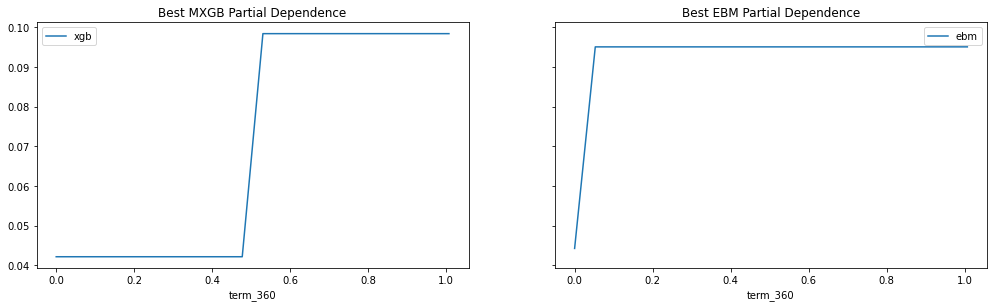

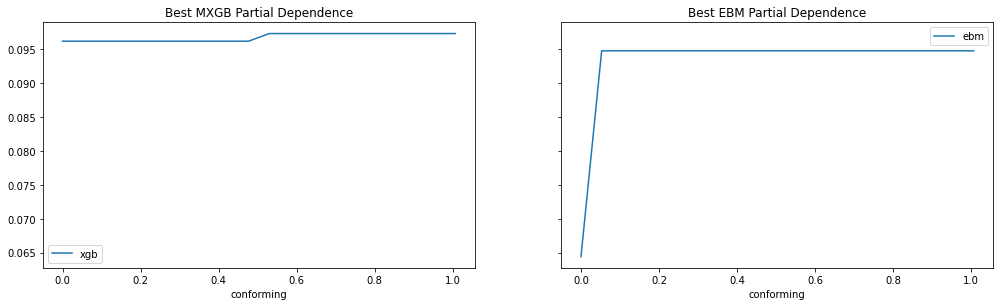

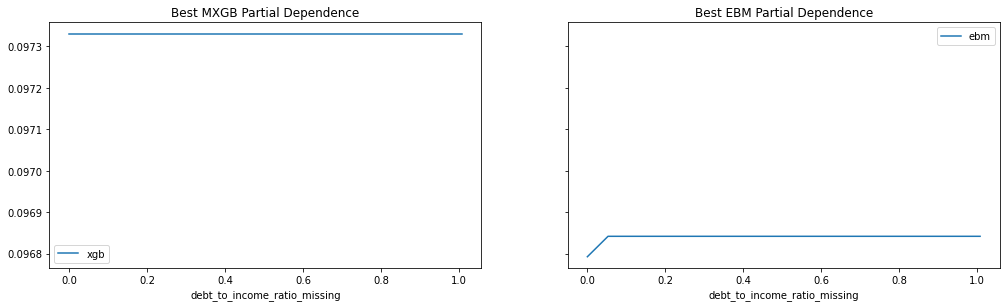

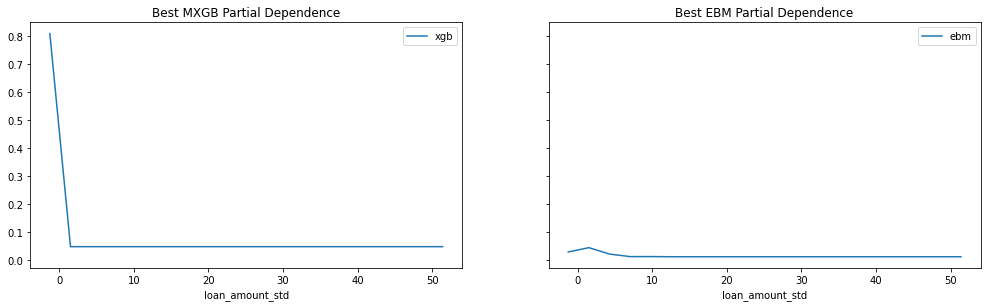

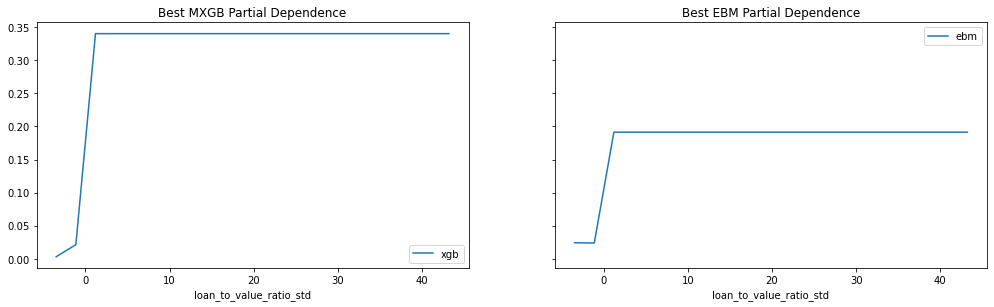

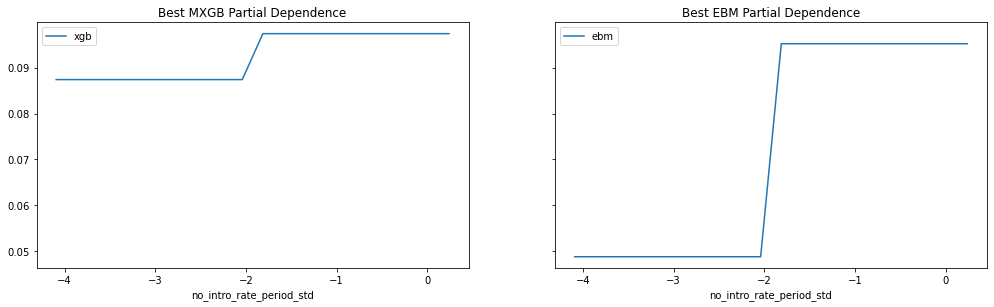

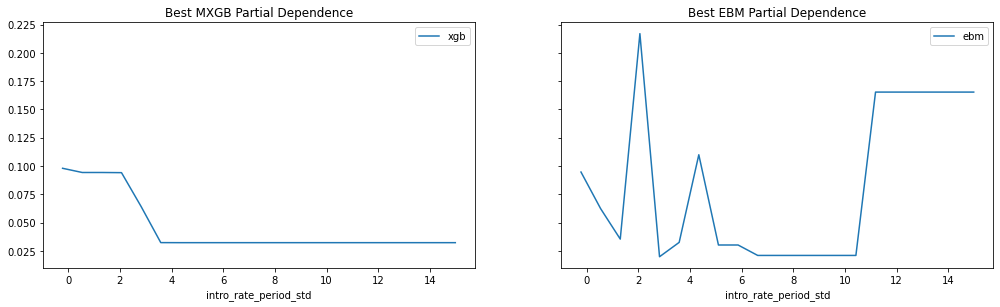

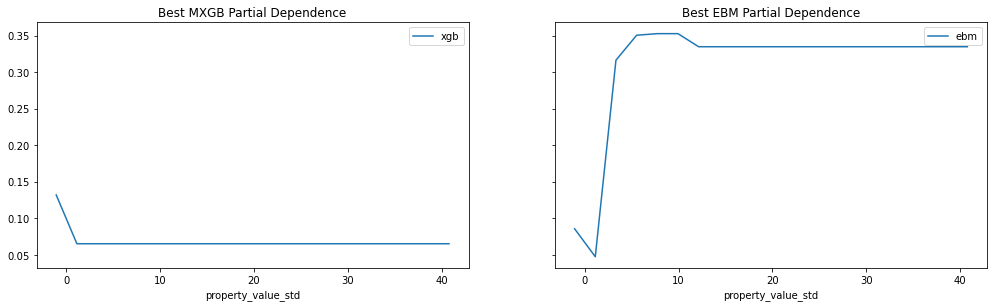

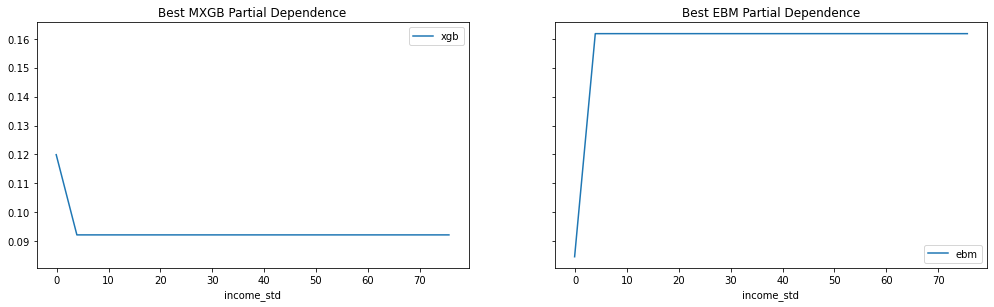

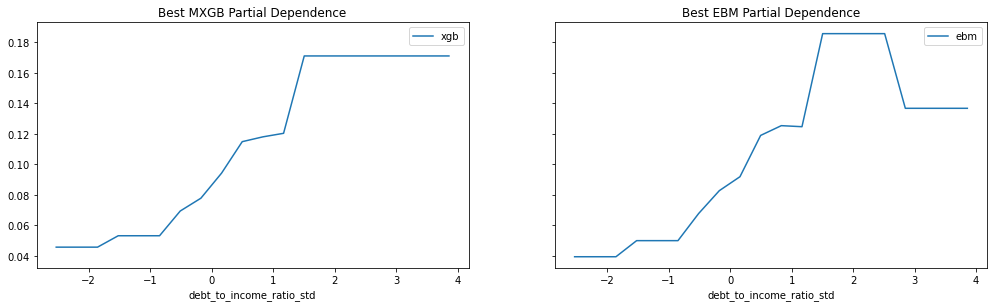

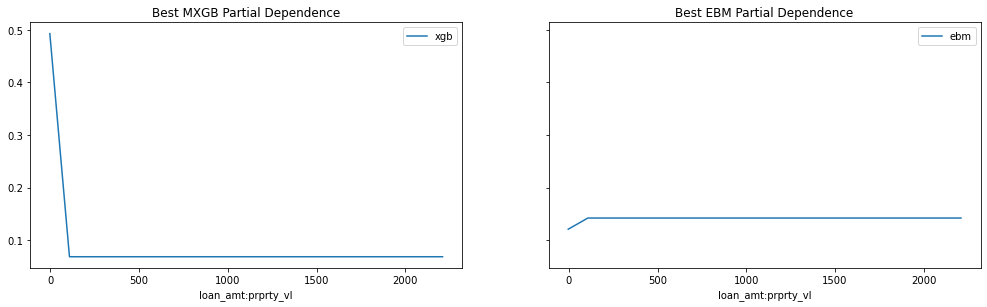

In [36]:
# loop through names to calculate par dep
for name in x_names:
   
    # init 2-pane plot
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2) # this may need to be changed
 
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax0, title='Best MXGB Partial Dependence')
    ax0.set_xlabel(name)
    
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax1, title='Best EBM Partial Dependence')
    ax1.set_xlabel(name)

### 3. ICE 

### Select percentiles from the predictions
